<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Modelling lab: Can we predict US government bond interest rates from financial news headlines?

In this exercise we'll combine two datasets, government bond interest rates from the US treasury and business/financial news headlines from various sources, to see if we can predict the changes in interest rates from the news. The question we're getting at is: do news headlines give us an indication of future changes in interest rates?

# Part 1 - US treasury data

The data for this comes [from the Federal Reserve](https://www.federalreserve.gov/releases/H15/default.htm) and is the file `FRB_H15.csv` in the `data` folder.

### 1. Load in the data, making sure excess headers are dealt with

In [1]:
import pandas as pd

df_rates = pd.read_csv("../data/FRB_H15.csv", header=None, skiprows=6, names=["date", "rate"])
df_rates.head(10)

,date,rate
0,2000-01-01,3.99
1,2000-01-02,3.99
2,2000-01-03,5.43
3,2000-01-04,5.38
4,2000-01-05,5.41
5,2000-01-06,5.54
6,2000-01-07,5.61
7,2000-01-08,5.61
8,2000-01-09,5.61
9,2000-01-10,5.74


### 2. Make sure the columns are appropriate types, converting as necessary

Are there any missing values?

In [2]:
df_rates.dtypes

date     object
rate    float64
dtype: object

In [3]:
df_rates["date"] = pd.to_datetime(df_rates["date"])
df_rates.isnull().sum()

date    0
rate    0
dtype: int64

### 3. Plot the time series to get a feel for the data

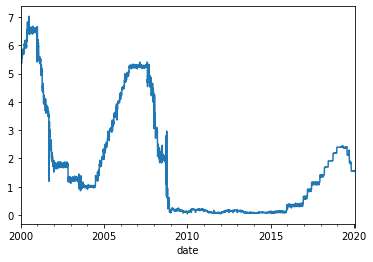

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

df_rates.set_index("date")["rate"].plot();

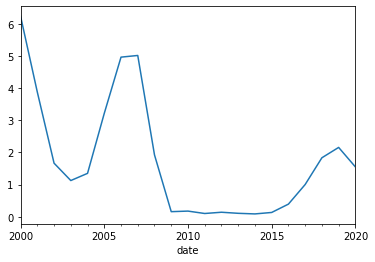

In [5]:
# annual average to smooth things out a bit
df_rates.set_index("date").resample("YS")["rate"].mean().plot();

### 4. Plot the time series for 2014 only

The news dataset is from 2014, so let's get a feel for the interest rates in that year only.

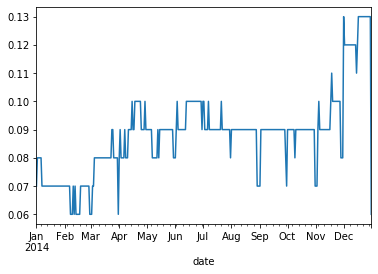

In [6]:
df_rates[df_rates["date"].dt.year == 2014].set_index("date")["rate"].plot();

### 5. Add a "change from yesterday" column

Rather than predicting the interest rate itself we'll try to predict the overnight change in the value from news items on the previous day. For that we'll need a target column, which is the change in interest rate from the day before.

Create this column.

In [7]:
df_rates["change"] = df_rates["rate"] - df_rates["rate"].shift()

# necessarily have to drop NULLs
print(len(df_rates))
df_rates.dropna(inplace=True)
print(len(df_rates))

df_rates.head()

7336
7335


,date,rate,change
1,2000-01-02,3.99,0.00
2,2000-01-03,5.43,1.44
3,2000-01-04,5.38,-0.05
4,2000-01-05,5.41,0.03
5,2000-01-06,5.54,0.13


# Part 2 - News

Our news headline data comes from the UCI Machine Learning repository ([via Kaggle](https://www.kaggle.com/uciml/news-aggregator-dataset)). The news dataset originally has multiple categories, but the file provided for this exercise is limited to the "business" category.

### 1. Read in the data

The file is zipped to reduce its size, but `pandas` can actually open CSVs if they're in a Gzip archive directly (you don't have to do the unzipping yourself).

In [8]:
df_news = pd.read_csv("../data/business-news.csv.gz")
df_news.head()

,TITLE,PUBLISHER,TIMESTAMP,URL
0,"Fed official says weak data caused by weather,...",Los Angeles Times,1394470370698,http://www.latimes.com/business/money/la-fi-mo...
1,Fed's Charles Plosser sees high bar for change...,Livemint,1394470371207,http://www.livemint.com/Politics/H2EvwJSK2VE6O...
2,US open: Stocks fall after Fed official hints ...,IFA Magazine,1394470371550,http://www.ifamagazine.com/news/us-open-stocks...
3,"Fed risks falling 'behind the curve', Charles ...",IFA Magazine,1394470371793,http://www.ifamagazine.com/news/fed-risks-fall...
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,Moneynews,1394470372027,http://www.moneynews.com/Economy/federal-reser...


### 2. Do the usual sense checking of the dataset

- how many rows are there?
- are there missing values?
- what are the data types?

In [9]:
df_news.shape

(115967, 4)

In [10]:
df_news.isnull().sum()

TITLE        0
PUBLISHER    1
TIMESTAMP    0
URL          0
dtype: int64

In [11]:
df_news[df_news["PUBLISHER"].isnull()]

,TITLE,PUBLISHER,TIMESTAMP,URL
1209,Federal Prosecutors Want Cash From Denver Pot ...,NaN,1394565833004,http://denver.cbslocal.com/2014/03/10/federal-...


### 3. Convert the "timestamp" column to a date type

Have a read of [the data documentation](http://archive.ics.uci.edu/ml/datasets/News+Aggregator) on the UCI ML repository site to see what format the column is currently in (if it's not a format you've come across before).

In [12]:
# convert to datetime but remove time (not interested in the time at this stage)
df_news["date"] = pd.to_datetime(df_news["TIMESTAMP"], unit="ms").dt.date

# extracting just the date makes a string column so re-cast as date
df_news["date"] = pd.to_datetime(df_news["date"])

df_news.head()

,TITLE,PUBLISHER,TIMESTAMP,URL,date
0,"Fed official says weak data caused by weather,...",Los Angeles Times,1394470370698,http://www.latimes.com/business/money/la-fi-mo...,2014-03-10
1,Fed's Charles Plosser sees high bar for change...,Livemint,1394470371207,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,2014-03-10
2,US open: Stocks fall after Fed official hints ...,IFA Magazine,1394470371550,http://www.ifamagazine.com/news/us-open-stocks...,2014-03-10
3,"Fed risks falling 'behind the curve', Charles ...",IFA Magazine,1394470371793,http://www.ifamagazine.com/news/fed-risks-fall...,2014-03-10
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,Moneynews,1394470372027,http://www.moneynews.com/Economy/federal-reser...,2014-03-10


### 4. Sanity check your date column by looking at what time period it covers (should be dates within 2014)

In [13]:
df_news["date"].agg(["min", "max"])

min   2014-03-10
max   2014-08-28
Name: date, dtype: datetime64[ns]

# Part 3 - Merging the datasets

Now it's time to combine the two datasets.

We want to make sure the dataset accurately reflects the data generating process, so join the news headlines with the interest rates making sure that the date for the headlines is the day *before* the interest rates. We therefore assume that any effect of what's happening in the news takes a day to happen. You can always tweak this assumption later!

### 1. Create a column in your news dataset called "next day" to store the date + 1 day

*Hint: the `datetime` library has a section called `timedelta` that will help!*

In [14]:
import datetime

df_news["next_day"] = df_news["date"] + datetime.timedelta(days=1)
df_news[["date", "next_day"]].head()

,date,next_day
0,2014-03-10,2014-03-11
1,2014-03-10,2014-03-11
2,2014-03-10,2014-03-11
3,2014-03-10,2014-03-11
4,2014-03-10,2014-03-11


### 2. Merge the two datasets

Join the rates data to the news data. Remember to join on the "next day" column instead of the original date in your news dataset.

After joining ensure the dataset has the same number of rows as your news dataset (to verify the join).

In [15]:
print(df_news.shape)

df_merged = (df_news
                 .drop("date", axis=1) # to avoid duplication
                 .merge(df_rates.rename(columns={"rate": "interest_rate",
                                                 "change": "interest_rate_change"}),
                        left_on="next_day",
                        right_on="date"))
print(df_merged.shape)
df_merged.head()

(115967, 6)
(115967, 8)


,TITLE,PUBLISHER,TIMESTAMP,URL,next_day,date,interest_rate,interest_rate_change
0,"Fed official says weak data caused by weather,...",Los Angeles Times,1394470370698,http://www.latimes.com/business/money/la-fi-mo...,2014-03-11,2014-03-11,0.08,0.0
1,Fed's Charles Plosser sees high bar for change...,Livemint,1394470371207,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,2014-03-11,2014-03-11,0.08,0.0
2,US open: Stocks fall after Fed official hints ...,IFA Magazine,1394470371550,http://www.ifamagazine.com/news/us-open-stocks...,2014-03-11,2014-03-11,0.08,0.0
3,"Fed risks falling 'behind the curve', Charles ...",IFA Magazine,1394470371793,http://www.ifamagazine.com/news/fed-risks-fall...,2014-03-11,2014-03-11,0.08,0.0
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,Moneynews,1394470372027,http://www.moneynews.com/Economy/federal-reser...,2014-03-11,2014-03-11,0.08,0.0


# Part 3 - Feature creation

### 1. Separate your dataset into training and test sets

Your training and test features should only contain the titles for now, and your training/test targets are your interest rate changes.

We want to do this *before* creating text features, because our vocabulary should come from our **training set only**.

Remember, the test set is information you haven't seen yet, so words in those headlines shouldn't count!

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_merged["TITLE"], df_merged["interest_rate_change"],
                                                    test_size=0.3,
                                                    random_state=42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

81176 81176 34791 34791


### 2. Create text features using the `TfidfVectorizer`

Now we want to create features that represent the TF-IDF scores of the `N` most common (non-stopword) words.

Try `N`=100 for now.

Use scikit-learn's `TfidfVectorizer` to create a document term matrix of 100 columns, one row per news headline, using the **training set only**.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(stop_words="english",
                            min_df=2, # ignore words that only appear once
                            max_features=100)

X_train_transformed = tfidf_vec.fit_transform(X_train)

### 2. Examine the vocabulary in your `TfidfVectorizer`

What are the top 100 words it picked out?

In [18]:
tfidf_vec.vocabulary_

{'week': 96,
 'airlines': 2,
 'malaysia': 48,
 'search': 80,
 'missing': 55,
 'russia': 77,
 'home': 39,
 'mh370': 53,
 'plane': 65,
 'new': 59,
 'wall': 95,
 'record': 73,
 'data': 16,
 'month': 56,
 'low': 46,
 'company': 15,
 'million': 54,
 'day': 17,
 'world': 97,
 'stocks': 83,
 'time': 87,
 'ukraine': 92,
 'higher': 38,
 'ahead': 1,
 'profit': 68,
 'business': 10,
 'rises': 76,
 'american': 5,
 'global': 32,
 'markets': 51,
 'shares': 81,
 'dollar': 19,
 'jobs': 43,
 'report': 74,
 'june': 44,
 'target': 85,
 'sales': 78,
 'price': 66,
 'health': 36,
 'gas': 31,
 'oil': 61,
 'ecb': 23,
 'earnings': 22,
 'news': 60,
 'lower': 47,
 'prices': 67,
 'rise': 75,
 'percent': 63,
 'march': 49,
 'gold': 34,
 'says': 79,
 'economy': 24,
 'street': 84,
 'fed': 29,
 'rates': 72,
 'pfizer': 64,
 'bid': 7,
 'growth': 35,
 'amazon': 4,
 'q1': 69,
 'billion': 9,
 'pay': 62,
 'year': 98,
 'stock': 82,
 'deal': 18,
 'alibaba': 3,
 'ipo': 41,
 'euro': 25,
 'buy': 11,
 '2014': 0,
 'uk': 91,
 'china

In [19]:
X_train_transformed

<81176x100 sparse matrix of type '<class 'numpy.float64'>'
	with 119633 stored elements in Compressed Sparse Row format>

### 3. Transform your test set using your trained vectorizer

You should now have a 100-column training set - each column representing a word, and each value representing the TF-IDF score of that word in each title.

Use your trained vectorizer object to create a 100-column test set using the set-aside test set titles.

In [20]:
X_test_transformed = tfidf_vec.transform(X_test)
X_test_transformed

<34791x100 sparse matrix of type '<class 'numpy.float64'>'
	with 51185 stored elements in Compressed Sparse Row format>

### 4. Rename columns in the training set

Use your vectorizer's `vocabulary_` dictionary to get your keys (they need to be sorted alphabetically to correspond to the document-term matrix).

Your training dataset should look something like this:

| ahead | airlines | american | ... |
|---------|---------|------|------|
| 0.45 | 0.3 | `NaN` | ... |

In [21]:
# create a new DataFrame from the underlying values in the vectorizer
# and name them after a sorted(!) copy of the vocabulary dictionary's keys
X_train_enhanced = pd.DataFrame(X_train_transformed.toarray(), columns=sorted(tfidf_vec.vocabulary_.keys()))
X_train_enhanced.head()

,2014,ahead,airlines,alibaba,amazon,american,bank,bid,big,billion,...,twitter,uk,ukraine,unemployment,update,wall,week,world,year,yellen
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Part 5 - Prediction!

### 1. Examine your target (in the training set) - what is the distribution (i.e. what is a credible range for predictions)?

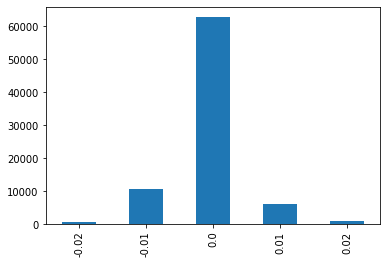

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

y_train.round(2).value_counts().sort_index().plot.bar();

Values are mostly 0, and all between -0.02 and +0.02

### 2. Compare the cross-validated performance of two different prediction models

For this you'll need to:

- choose the appropriate type of model (is this classification or regression?)
- based on the above, come up with an appropriate metric to measure performance
- choose two appropriate algorithms to compare with one another
- run both models (with cross-validation) and examine your results!

In [25]:
# model 1: linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lr = LinearRegression()

cross_val_score(lr,
                X=X_train_enhanced, # use the 100-column version obviously!
                y=y_train,
                cv=5,
                scoring="neg_root_mean_squared_error")

array([-0.00527064, -0.00535268, -0.00520851, -0.00520652, -0.00530482])

Not bad really, values range from -0.02 to 0.02 so to be 0.005 out on average is OK!

In [26]:
# model 2: random forest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=11, # random odd number
                           min_samples_leaf=10, # don't let trees get TOO out of hand
                           random_state=42
                          )

cross_val_score(rf,
                X=X_train_enhanced,
                y=y_train,
                cv=3,
                scoring="neg_root_mean_squared_error")

array([-0.00523966, -0.00518153, -0.00522214])

Random forest performs about the same it seems, perhaps a bit better but still with some variance

### 3. Compare your models' feature importance - what words are important to predict interest rate changes?

In [28]:
# fit both models
lr.fit(X_train_enhanced, y_train)
rf.fit(X_train_enhanced, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=11, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

Feature importance - linear regression

Magnitude is important, not the sign, so sort by *absolute* coefficient value

In [29]:
sorted(list(zip(lr.coef_, X_train_enhanced.columns)), key=lambda x:abs(x[0]), reverse=True)[:10]

[(0.004217628413399183, 'mortgage'),
 (0.003591456065370474, 'yellen'),
 (0.0018202375266644759, 'unemployment'),
 (-0.00178388099409326, 'record'),
 (0.0016767947738263798, 'gas'),
 (-0.0015995924480447904, 'dow'),
 (0.001549483146334242, 'gold'),
 (-0.00138547965185415, 'russia'),
 (0.0013145630291348748, 'day'),
 (-0.0013105566655261928, 'month')]

Feature importance - random forest

In [30]:
sorted(list(zip(rf.feature_importances_, X_train_enhanced.columns)), key=lambda x:x[0], reverse=True)[:10]

[(0.04960558732834044, '2014'),
 (0.04187303370361372, 'yellen'),
 (0.034030529207146026, 'mortgage'),
 (0.030441530784646006, 'day'),
 (0.028500406822555634, 'sales'),
 (0.027522819222721786, 'march'),
 (0.02727210079436363, 'rates'),
 (0.0248235062865124, 'twitter'),
 (0.023150620543562664, 'bank'),
 (0.021857902319156436, 'stocks')]

### 4. Try something to improve one of your models

Some ideas:

- change the number of features (is more or less than 100 a good idea? This may depend on which words your model thought important)
- tune the hyperparameters using grid search
- try something more radical and predict the rates themselves, not the changes

In [31]:
# try lasso regularisation
# with grid search to find a good regularisation coefficient
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

import numpy as np # for "logspace", getting different alpha values in multiples of 10

grid = GridSearchCV(estimator=Lasso(),
                    param_grid={"alpha": np.logspace(-5, 5, 11)},
                    cv=3,
                    scoring="neg_root_mean_squared_error")

grid.fit(X_train_enhanced, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [32]:
grid.best_score_

-0.00529282468385945

In [33]:
grid.best_params_

{'alpha': 1e-05}

Looks like that hasn't helped, but maybe we have some feature selection as a bonus

In [34]:
feature_importances = list(zip(grid.best_estimator_.coef_, X_train_enhanced.columns))

# only look at nonzeros
sorted([f for f in feature_importances if f[0] != 0], key=lambda x: abs(x[0]), reverse=True)

[(0.0021229697672433246, 'mortgage'),
 (0.0020102165946802664, 'yellen'),
 (0.0004171223823519581, 'bank'),
 (0.000369530187707698, 'earnings'),
 (-0.0003691687157420364, 'amazon'),
 (-8.805618243374995e-05, 'business'),
 (5.145904894555951e-05, 'gold'),
 (3.7424312593287124e-05, 'day'),
 (1.873108831112949e-05, 'stocks')]

The important features remain, but we have a model with much fewer features used

### 5. Evaluate the best version of your best model on the test set - how did it perform?

In [35]:
from sklearn.metrics import mean_squared_error

# not much difference between standard, and regularised LR, but let's pick the lasso model
# as it uses fewer features
y_test_pred = grid.best_estimator_.predict(X_test_transformed)

np.sqrt(mean_squared_error(y_test, y_test_pred))

0.005337414185098864